In [9]:
# ELECTRICAL ASSET INTELLIGENCE PLATFORM
# 02: Anomaly Detection Notebook
# SPE AI/ML Boot Camp Final Project

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

# Use seaborn theme (reliable) instead of plt.style.use('seaborn-whitegrid')
sns.set_theme(style="whitegrid", palette="viridis")

# Create results directory if it doesn't exist
if not os.path.exists('../results'):
    os.makedirs('../results')

In [10]:
# Load and preprocess data
print("Loading electrical asset datasets...")

def load_and_preprocess_data(asset_type):
    """Load and preprocess data for anomaly detection"""
    df = pd.read_csv(f'../data/{asset_type}_data.csv')
    
    # Convert date to datetime and sort
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    
    # Drop non-numeric columns and date
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols].drop(['health_status_num'], axis=1, errors='ignore')
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Get health status for evaluation
    y = df['health_status'].map({'Healthy': 0, 'Warning': 1, 'Critical': 2})
    
    return X_scaled, y, df

# Load all datasets
transformer_X, transformer_y, transformer_df = load_and_preprocess_data('transformer')
motor_X, motor_y, motor_df = load_and_preprocess_data('motor')
capacitor_X, capacitor_y, capacitor_df = load_and_preprocess_data('capacitor')
ups_X, ups_y, ups_df = load_and_preprocess_data('ups')

Loading electrical asset datasets...


In [11]:
# 1. Isolation Forest Anomaly Detection
print("\nTraining Isolation Forest models...")

def train_isolation_forest(X, contamination=0.05):
    """Train an Isolation Forest model"""
    model = IsolationForest(
        n_estimators=100,
        max_samples='auto',
        contamination=contamination,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X)
    return model

def evaluate_isolation_forest(model, X, y):
    """Evaluate Isolation Forest model"""
    # Predict anomalies (-1 for anomalies, 1 for normal)
    y_pred = model.predict(X)
    
    # Convert to binary format (0 for normal, 1 for anomaly)
    y_pred_binary = np.where(y_pred == -1, 1, 0)
    
    # Convert true labels to binary (1 for Warning/Critical, 0 for Healthy)
    y_true_binary = np.where(y >= 1, 1, 0)
    
    # Calculate metrics
    results = {
        'anomaly_count': np.sum(y_pred == -1),
        'anomaly_percentage': np.mean(y_pred == -1) * 100
    }
    
    # Classification report
    results['classification_report'] = classification_report(
        y_true_binary, y_pred_binary, 
        target_names=['Normal', 'Anomaly']
    )
    
    # Confusion matrix
    results['confusion_matrix'] = confusion_matrix(y_true_binary, y_pred_binary)
    
    return results, y_pred_binary

# Train and evaluate for all assets
isolation_results = {}
isolation_predictions = {}

for asset_type, (X, y) in zip(
    ['transformer', 'motor', 'capacitor', 'ups'],
    [(transformer_X, transformer_y), (motor_X, motor_y), 
     (capacitor_X, capacitor_y), (ups_X, ups_y)]
):
    print(f"\nTraining Isolation Forest for {asset_type}...")
    
    # Train model
    model = train_isolation_forest(X)
    
    # Evaluate model
    results, predictions = evaluate_isolation_forest(model, X, y)
    isolation_results[asset_type] = results
    isolation_predictions[asset_type] = predictions
    
    # Save model
    import joblib
    if not os.path.exists('../models'):
        os.makedirs('../models')
    joblib.dump(model, f'../models/isolation_forest_{asset_type}.pkl')
    
    # Print results
    print(f"Anomalies detected: {results['anomaly_count']} ({results['anomaly_percentage']:.2f}%)")
    print("\nClassification Report:")
    print(results['classification_report'])



Training Isolation Forest models...

Training Isolation Forest for transformer...
Anomalies detected: 50 (5.00%)

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99       962
     Anomaly       0.60      0.79      0.68        38

    accuracy                           0.97      1000
   macro avg       0.80      0.88      0.83      1000
weighted avg       0.98      0.97      0.97      1000


Training Isolation Forest for motor...
Anomalies detected: 50 (5.00%)

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.98      0.96       916
     Anomaly       0.64      0.38      0.48        84

    accuracy                           0.93      1000
   macro avg       0.79      0.68      0.72      1000
weighted avg       0.92      0.93      0.92      1000


Training Isolation Forest for capacitor...
Anomalies detected: 50 (5.00%)

Classification Report:
              

In [17]:
# 2. LSTM Autoencoder Anomaly Detection
print("\nTraining LSTM Autoencoder models...")

def build_lstm_autoencoder(input_shape):
    """Build LSTM autoencoder for complex time-series anomaly detection"""
    model = Sequential([
        # Encoder
        LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='relu', return_sequences=False),
        Dropout(0.2),
        # Bottleneck
        Dense(16, activation='relu'),
        # Decoder
        Dense(32, activation='relu'),
        RepeatVector(input_shape[0]),
        LSTM(32, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(64, activation='relu', return_sequences=True),
        Dropout(0.2),
        TimeDistributed(Dense(input_shape[1]))
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

def detect_lstm_anomalies(X, window_size=30, asset_type="asset"):
    """Detect anomalies using LSTM autoencoder"""
    # Reshape for LSTM [samples, time steps, features]
    n_samples = X.shape[0] - window_size + 1
    X_reshaped = np.array([X[i:i+window_size] for i in range(n_samples)])
    
    # Build and train autoencoder
    input_shape = (window_size, X_reshaped.shape[2])
    autoencoder = build_lstm_autoencoder(input_shape)
    
    # Split data for training/validation
    from sklearn.model_selection import train_test_split
    X_train, X_val = train_test_split(X_reshaped, test_size=0.2, random_state=42)
    
    # Train model
    history = autoencoder.fit(
        X_train, X_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, X_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=0
    )
    
    # Save training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'LSTM Autoencoder Training - {asset_type.capitalize()}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(f'../results/lstm_autoencoder_training_{asset_type}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Reconstruct the training data
    X_pred = autoencoder.predict(X_reshaped, verbose=0)
    
    # Calculate reconstruction error
    mse = np.mean(np.power(X_reshaped - X_pred, 2), axis=(1, 2))
    
    # Determine threshold (95th percentile)
    threshold = np.percentile(mse, 95)
    
    # Identify anomalies
    anomalies = mse > threshold
    
    # Save the model
    autoencoder.save(f'../models/lstm_autoencoder_{asset_type}.h5')
    
    # Plot anomalies
    plt.figure(figsize=(14, 7))
    plt.plot(mse, label='Reconstruction Error')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')
    plt.scatter(np.where(anomalies)[0], mse[anomalies], c='r', label='Anomalies')
    plt.title(f'LSTM Anomaly Detection - {asset_type.capitalize()}')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.xlabel('Time Window')
    plt.legend()
    plt.savefig(f'../results/lstm_anomaly_detection_{asset_type}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return anomalies, mse, threshold

# Train and evaluate LSTM autoencoders for all assets
lstm_results = {}

for asset_type, X in zip(
    ['transformer', 'motor', 'capacitor', 'ups'],
    [transformer_X, motor_X, capacitor_X, ups_X]
):
    print(f"\nTraining LSTM Autoencoder for {asset_type}...")
    
    # Detect anomalies
    anomalies, mse, threshold = detect_lstm_anomalies(X, asset_type=asset_type)
    lstm_results[asset_type] = {
        'anomalies': anomalies,
        'mse': mse,
        'threshold': threshold
    }
    
    print(f"Anomalies detected: {np.sum(anomalies)} ({np.mean(anomalies)*100:.2f}%)")


Training LSTM Autoencoder models...

Training LSTM Autoencoder for transformer...


c:\Users\Crypto\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Anomalies detected: 49 (5.05%)

Training LSTM Autoencoder for motor...


Anomalies detected: 49 (5.05%)

Training LSTM Autoencoder for capacitor...


Anomalies detected: 49 (5.05%)

Training LSTM Autoencoder for ups...


Anomalies detected: 49 (5.05%)



Generating anomaly detection visualizations...

Asset: transformer
 numeric columns: ['oil_temp_c', 'winding_temp_c', 'load_percent', 'insulation_resistance_mohm', 'partial_discharge_pc', 'maintenance_performed']
 df_num.shape: (1000, 6)
 X.shape: (1000, 6)
 requested features: oil_temp_c winding_temp_c
 isolation_prediction present: True
 y_pred.shape: (1000,)  y_pred[:5]: [0 0 0 0 0]


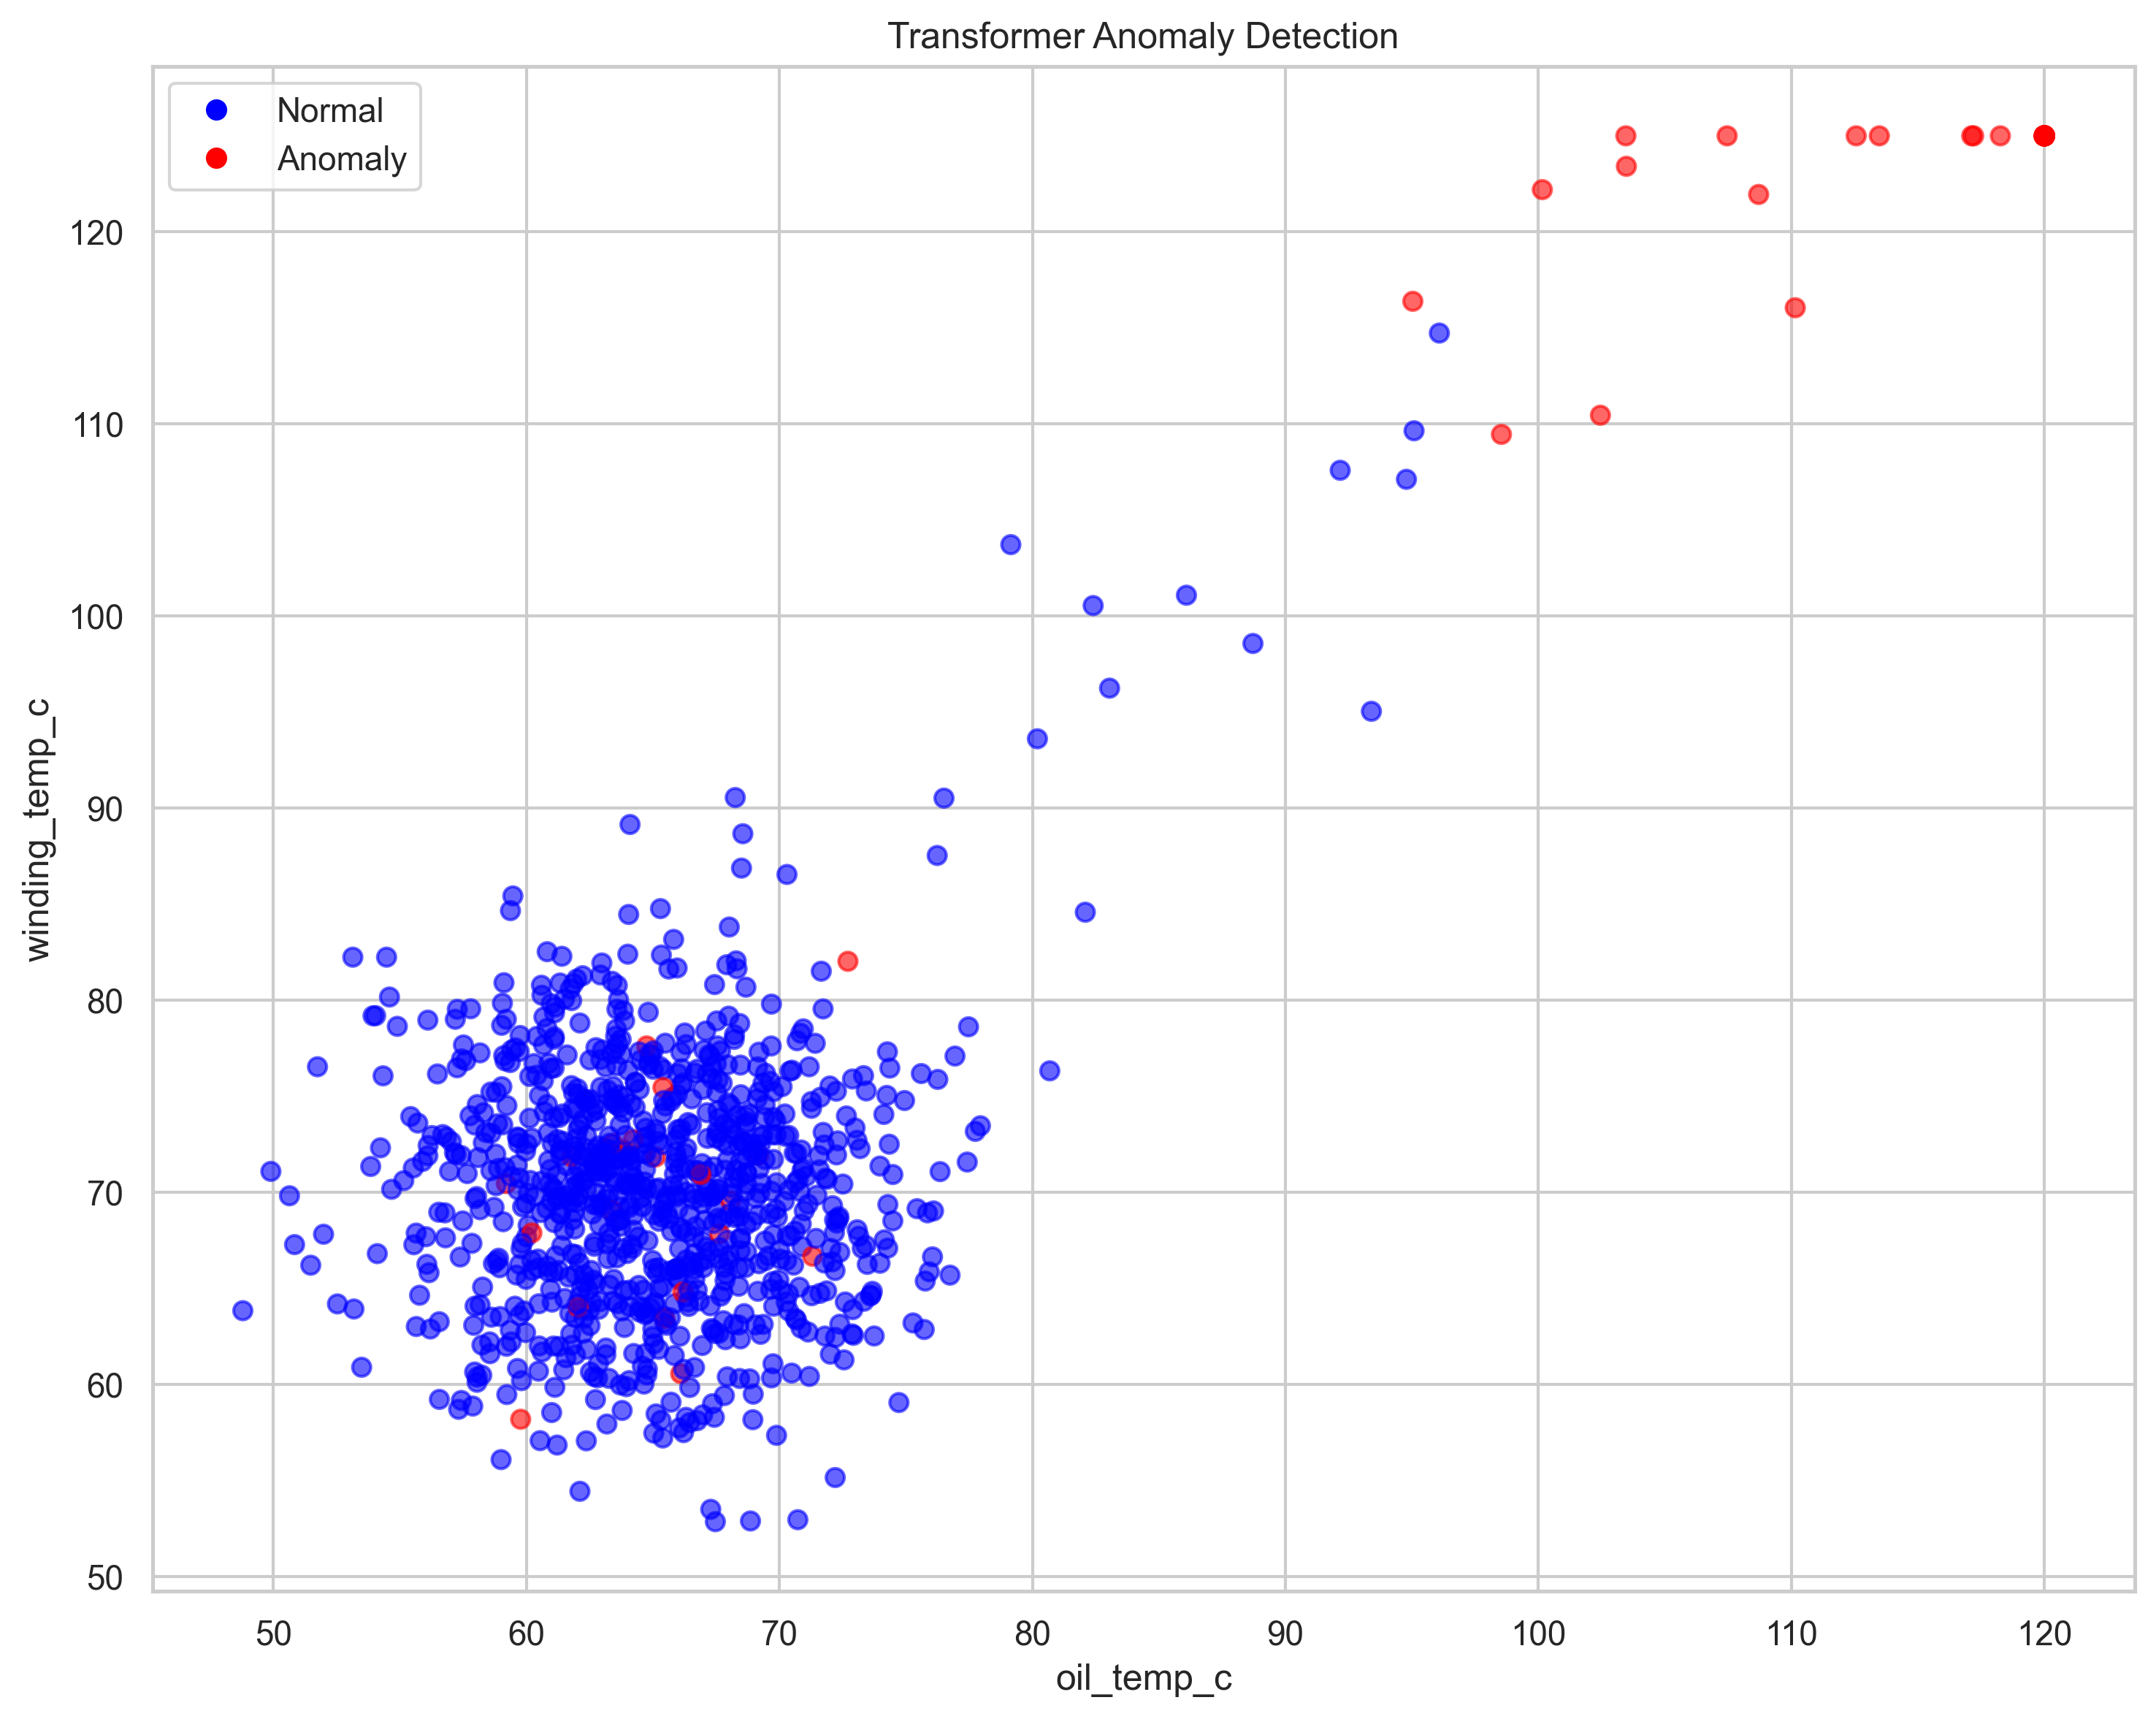


Asset: motor
 numeric columns: ['vibration_mm_s', 'current_a', 'voltage_v', 'power_factor', 'temperature_c', 'runtime_hours']
 df_num.shape: (1000, 6)
 X.shape: (1000, 6)
 requested features: vibration_mm_s temperature_c
 isolation_prediction present: True
 y_pred.shape: (1000,)  y_pred[:5]: [0 0 0 0 0]


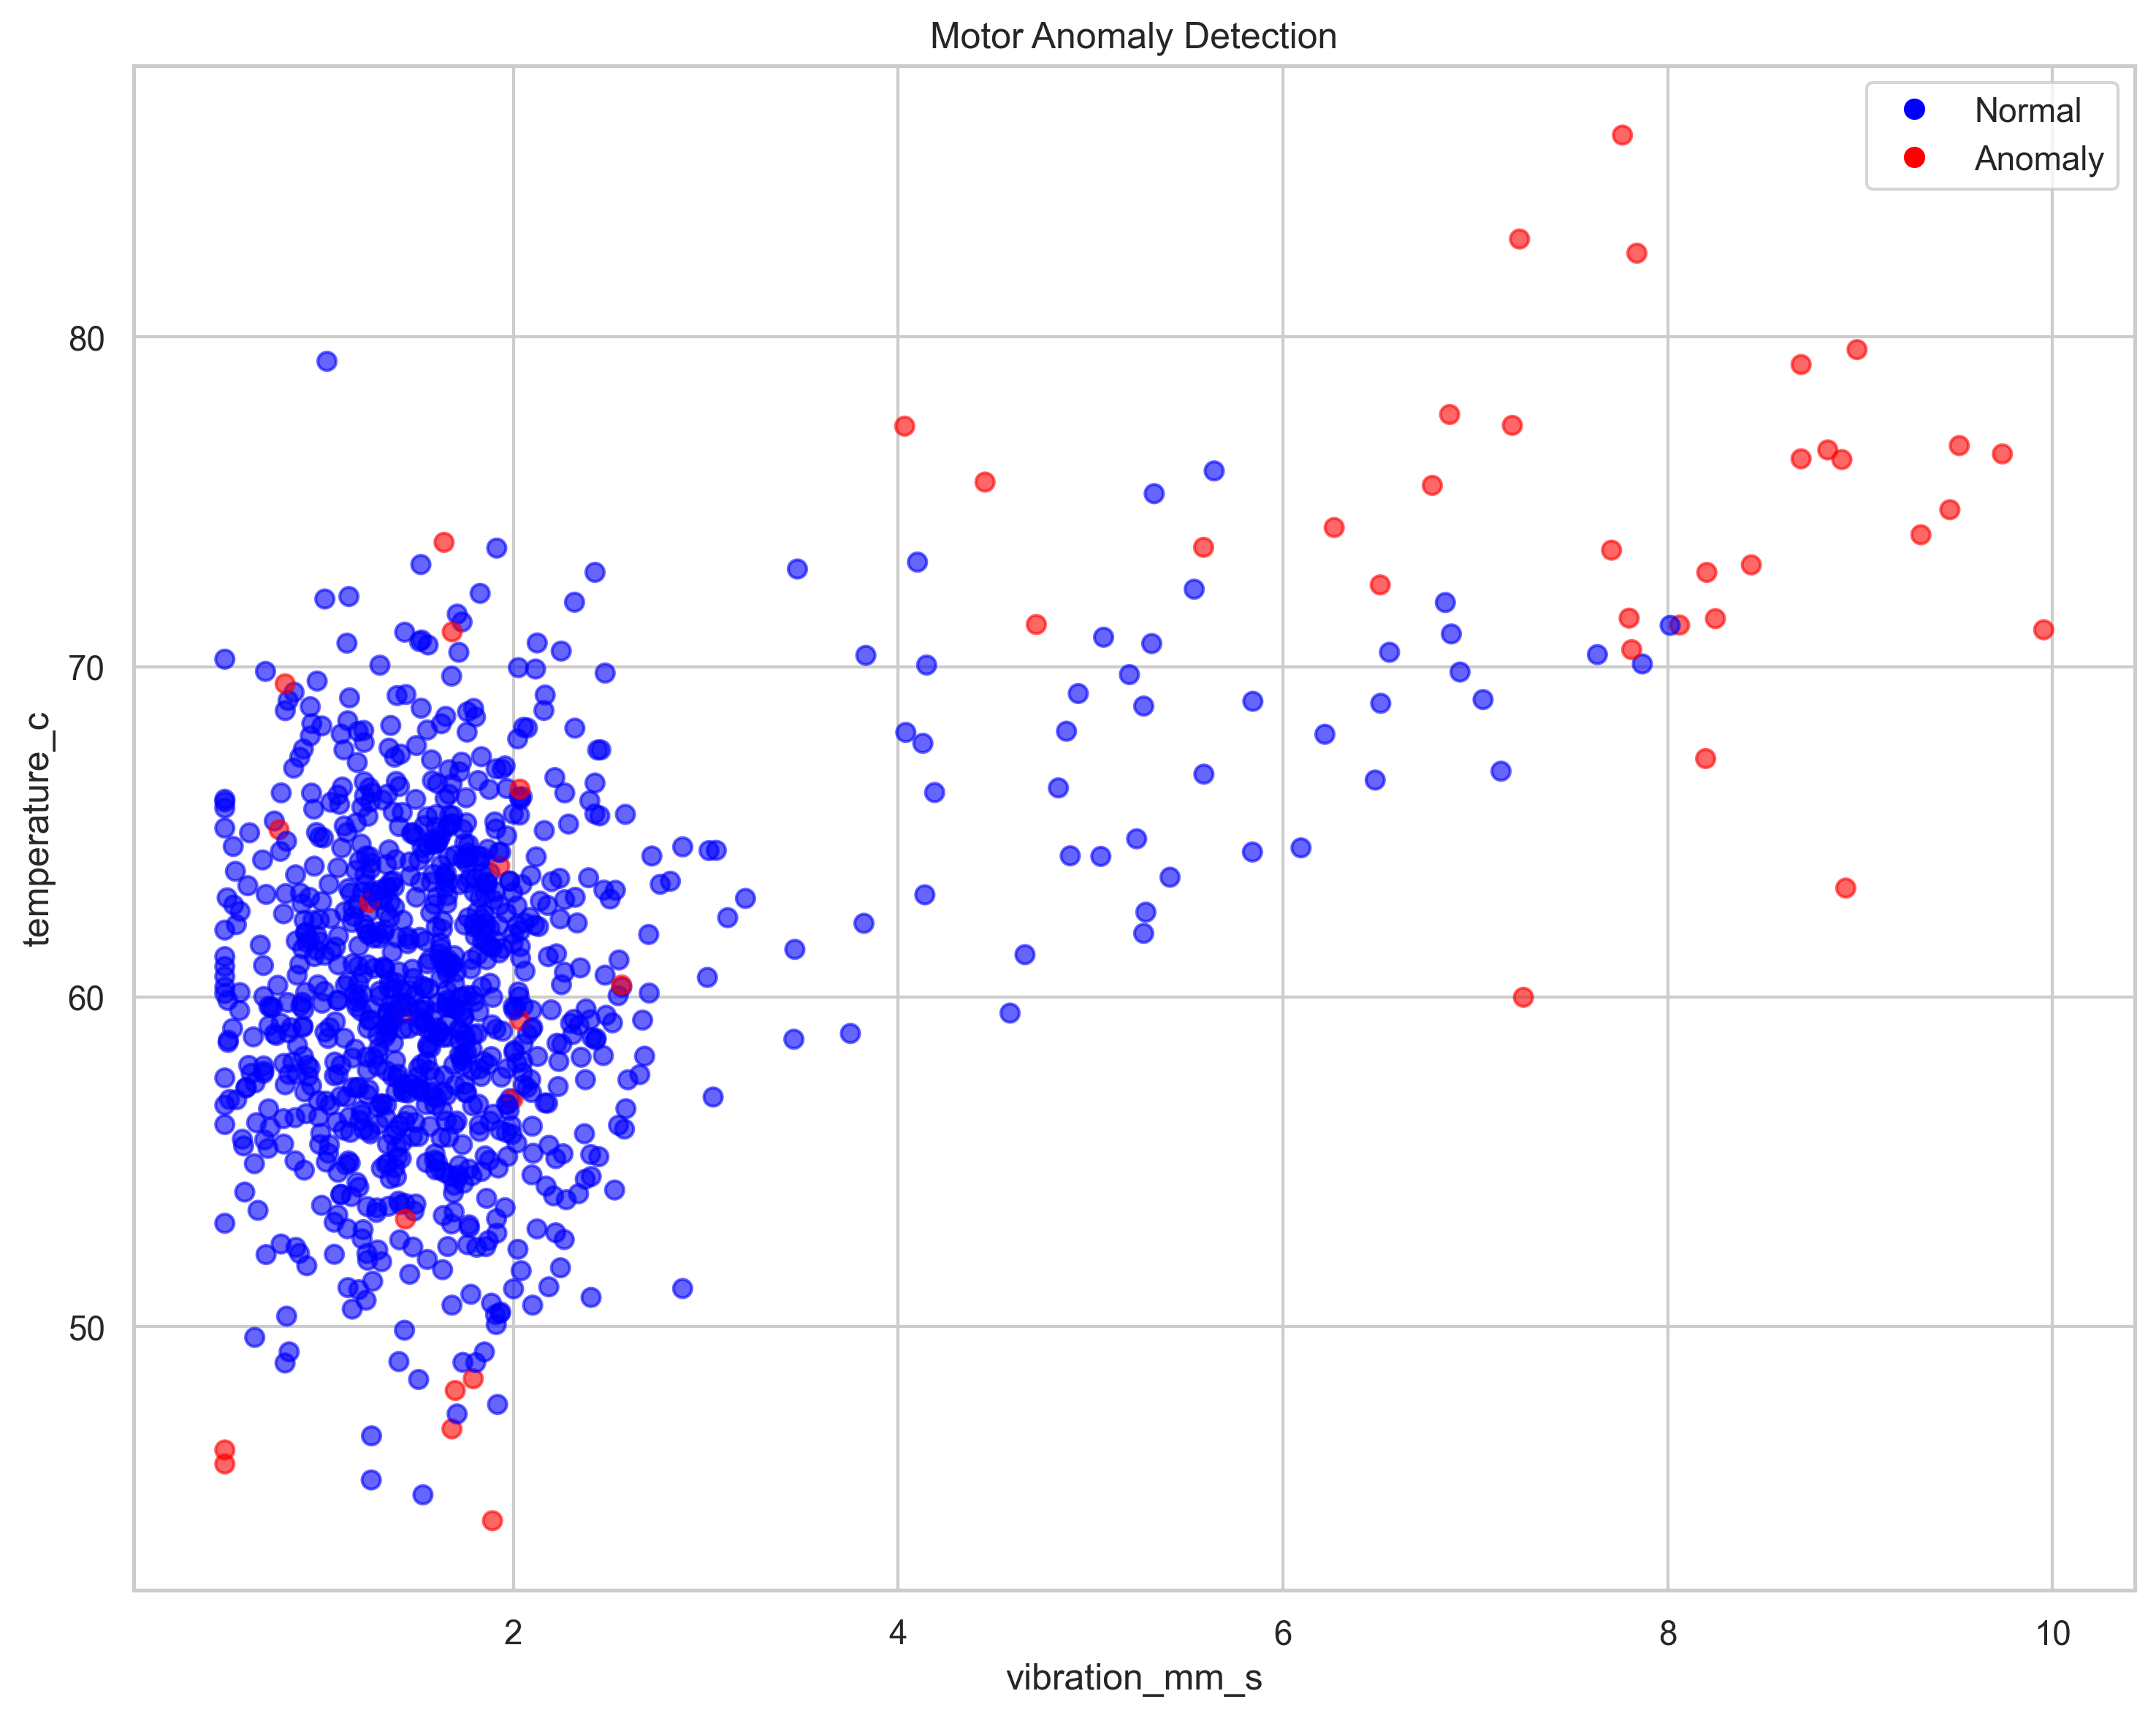


Asset: capacitor
 numeric columns: ['voltage_kv', 'current_a', 'power_factor', 'harmonic_distortion_percent', 'temperature_c', 'discharge_time_s']
 df_num.shape: (1000, 6)
 X.shape: (1000, 6)
 requested features: None None
 isolation_prediction present: True
 y_pred.shape: (1000,)  y_pred[:5]: [0 0 0 0 0]


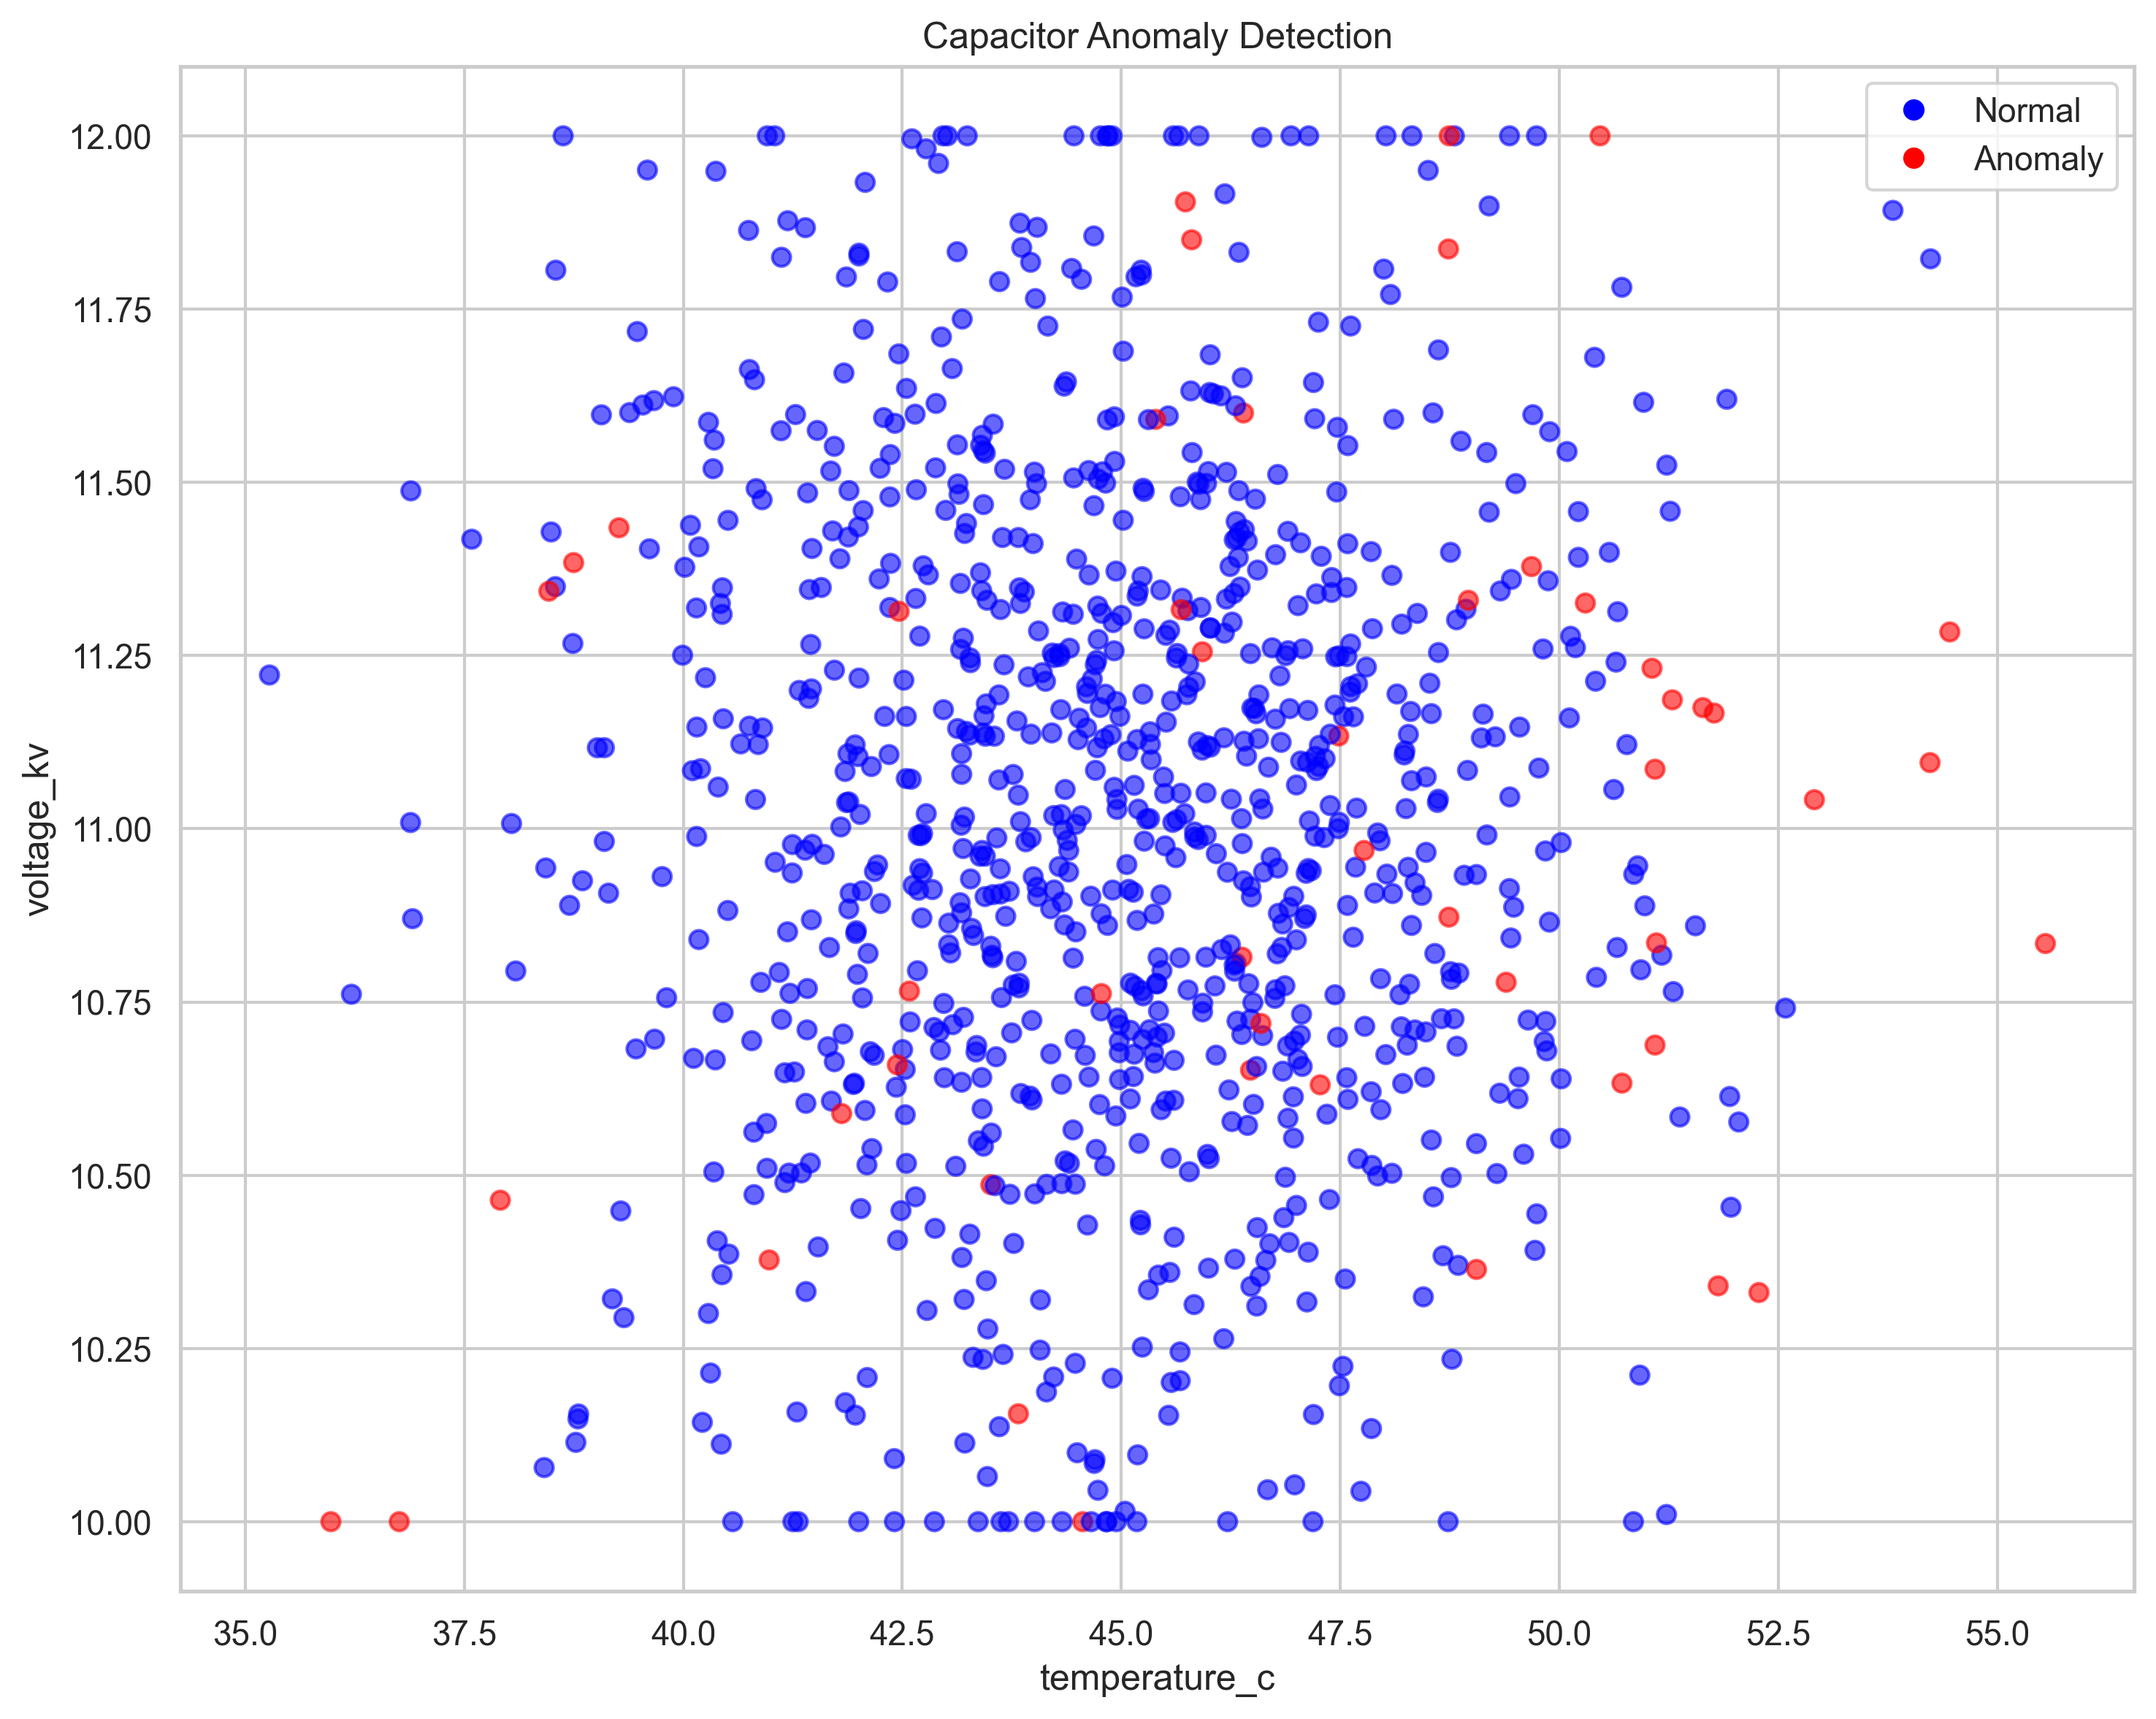


Asset: ups
 numeric columns: ['voltage_per_cell_v', 'temperature_c', 'load_percent', 'backup_time_min', 'charger_efficiency_percent']
 df_num.shape: (1000, 5)
 X.shape: (1000, 5)
 requested features: None None
 isolation_prediction present: True
 y_pred.shape: (1000,)  y_pred[:5]: [0 0 0 0 0]


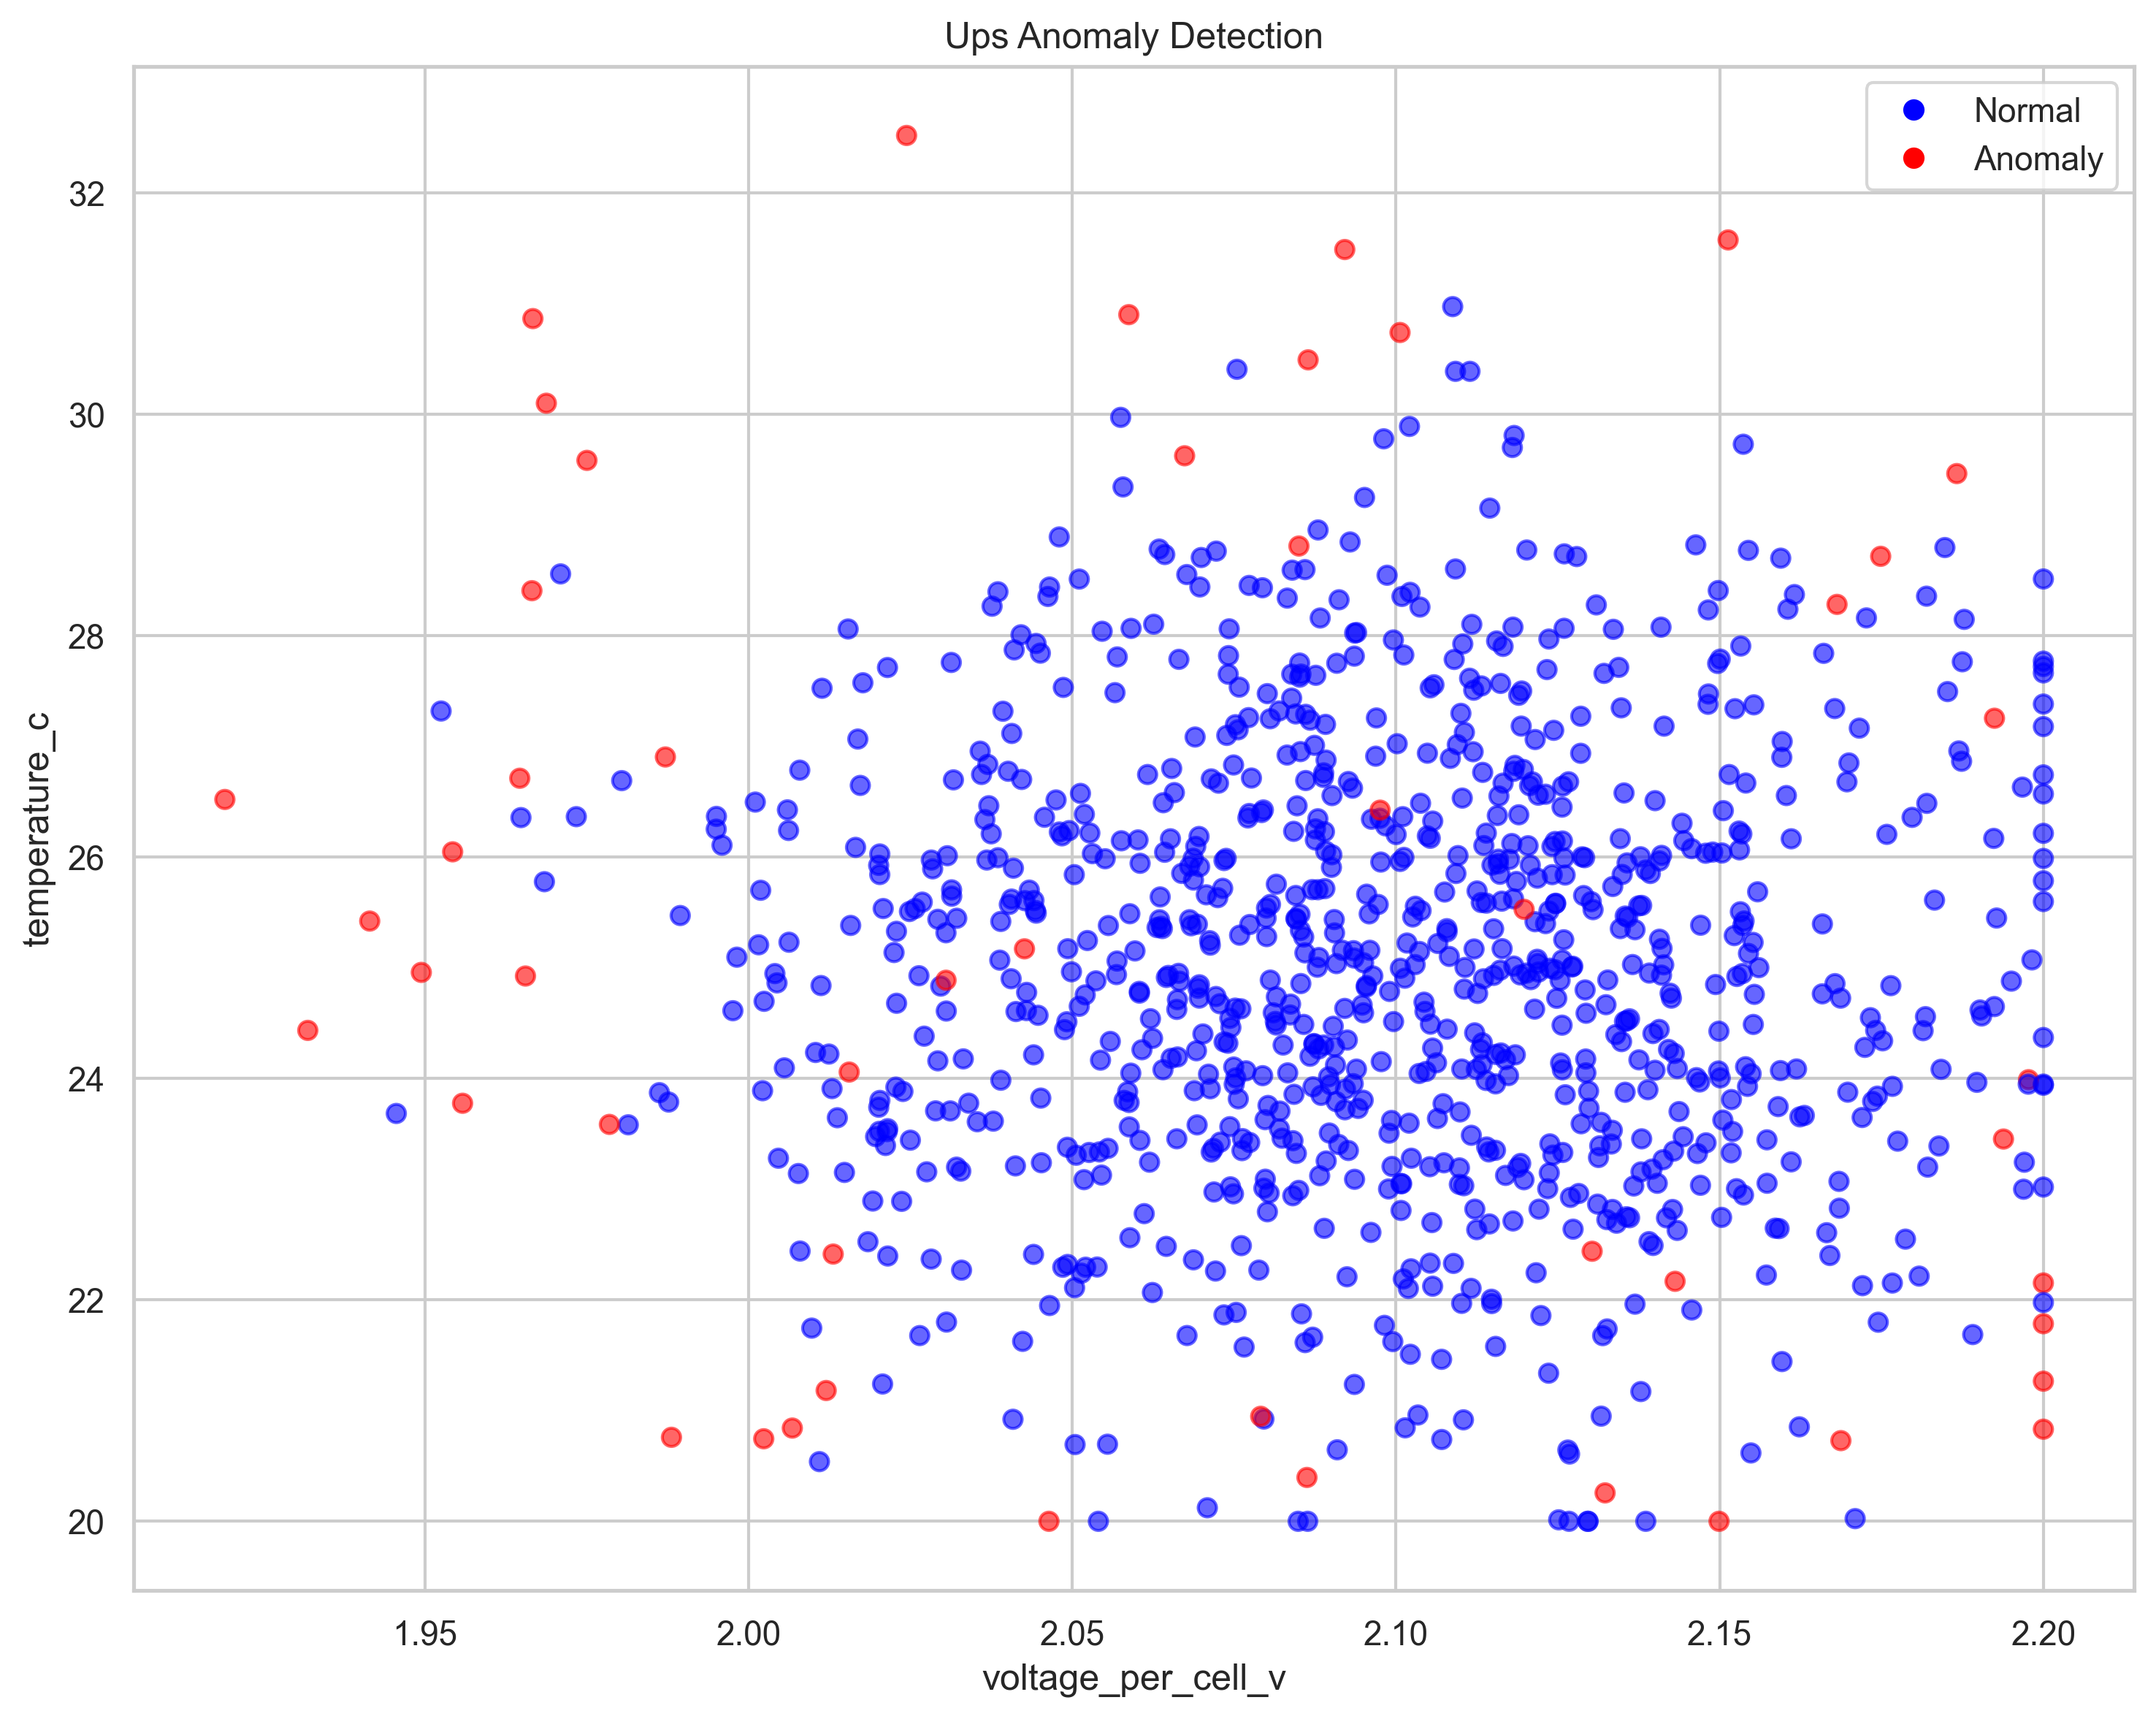


Saved plots:
 - ..\results\transformer_anomaly_oil_temp_c_winding_temp_c.png
 - ..\results\motor_anomaly_vibration_mm_s_temperature_c.png
 - ..\results\capacitor_anomaly_temperature_c_voltage_kv.png
 - ..\results\ups_anomaly_voltage_per_cell_v_temperature_c.png


In [31]:
# ...existing code...
# 3. Visualization of Anomaly Detection Results (enhanced capacitor/UPS logic + debug)
print("\nGenerating anomaly detection visualizations...")

from IPython.display import display, Image as IPImage
import os

RESULTS_DIR = os.path.join('..', 'results')
os.makedirs(RESULTS_DIR, exist_ok=True)

def _top_variance_pair(df):
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    nums = [c for c in nums if c != 'health_status_num']
    if not nums:
        return None, None
    var_sorted = sorted(nums, key=lambda x: df[x].var() if df[x].dtype.kind in 'fi' else 0, reverse=True)
    if len(var_sorted) == 1:
        return var_sorted[0], var_sorted[0]
    return var_sorted[0], var_sorted[1]

def _select_features_for_asset(df, asset_type):
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    nums = [c for c in nums if c != 'health_status_num']
    if not nums:
        return None, None

    if asset_type == 'capacitor':
        prefs = ['temperature_c', 'capacitance_pf', 'voltage_kv', 'current_a']
        found = [c for c in prefs if c in nums]
        if len(found) >= 2:
            return found[0], found[1]
        if len(found) == 1:
            others = [c for c in nums if c != found[0]]
            if others:
                var_sorted = sorted(others, key=lambda x: df[x].var(), reverse=True)
                return found[0], var_sorted[0]
            return found[0], found[0]
        return _top_variance_pair(df)

    if asset_type == 'ups':
        prefs = ['voltage_per_cell_v', 'load_current_a', 'temperature_c', 'soc_percent', 'battery_voltage_v']
        found = [c for c in prefs if c in nums]
        if len(found) >= 2:
            return found[0], found[1]
        if len(found) == 1:
            others = [c for c in nums if c != found[0]]
            if others:
                var_sorted = sorted(others, key=lambda x: df[x].var(), reverse=True)
                return found[0], var_sorted[0]
            return found[0], found[0]
        return _top_variance_pair(df)

    default_prefs = {
        'transformer': ['oil_temp_c', 'winding_temp_c'],
        'motor': ['vibration_mm_s', 'temperature_c']
    }
    prefs = default_prefs.get(asset_type, None)
    if prefs:
        found = [c for c in prefs if c in nums]
        if len(found) >= 2:
            return found[0], found[1]
        if len(found) == 1:
            others = [c for c in nums if c != found[0]]
            if others:
                var_sorted = sorted(others, key=lambda x: df[x].var(), reverse=True)
                return found[0], var_sorted[0]
            return found[0], found[0]

    return _top_variance_pair(df)

def plot_anomaly_results_df(df, X, y_pred, feature_x, feature_y, title, asset_type):
    """Plot using df (unscaled) and asset-specific selection when needed.
       Prints debug info similar to the example in the prompt."""
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    df_num = df[nums].drop(['health_status_num'], axis=1, errors='ignore').reset_index(drop=True)

    # Print debug info about dataset and requested features BEFORE selection/fallback
    isolation_present = ('isolation_predictions' in globals()) and (asset_type in globals().get('isolation_predictions', {}))
    print(f"\nAsset: {asset_type}")
    print(" numeric columns:", nums)
    print(" df_num.shape:", df_num.shape)
    print(" X.shape:", getattr(X, 'shape', None))
    print(" requested features:", feature_x, feature_y)
    print(" isolation_prediction present:", isolation_present)

    # If requested features None, select with asset logic
    if feature_x is None or feature_y is None:
        fx, fy = _select_features_for_asset(df, asset_type)
        feature_x = feature_x or fx
        feature_y = feature_y or fy

    # If still invalid, try asset-specific selection
    if feature_x not in df_num.columns or feature_y not in df_num.columns:
        fx, fy = _select_features_for_asset(df, asset_type)
        feature_x = feature_x if feature_x in df_num.columns else fx
        feature_y = feature_y if feature_y in df_num.columns else fy

    if feature_x is None or feature_y is None or feature_x not in df_num.columns or feature_y not in df_num.columns:
        print(f"Skipping {asset_type}: not enough numeric columns for plotting.")
        return None

    # Prepare y_pred aligned to rows
    if y_pred is None:
        y_pred = np.zeros(df_num.shape[0], dtype=int)
    else:
        y_pred = np.asarray(y_pred).astype(int)
        if len(y_pred) != df_num.shape[0]:
            if len(y_pred) > df_num.shape[0]:
                y_pred = y_pred[:df_num.shape[0]]
            else:
                y_pred = np.concatenate([y_pred, np.zeros(df_num.shape[0] - len(y_pred), dtype=int)])

    # Print y_pred shape and sample (debug) after alignment
    try:
        print(" y_pred.shape:", y_pred.shape, " y_pred[:5]:", y_pred[:5])
    except Exception:
        pass

    fx_vals = df_num[feature_x].values
    fy_vals = df_num[feature_y].values
    colors = np.array(['blue' if int(x) == 0 else 'red' for x in y_pred[:len(fx_vals)]])

    plt.figure(figsize=(10, 8))
    plt.scatter(fx_vals, fy_vals, c=colors, alpha=0.6)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(title)
    normal_handle = plt.Line2D([], [], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Normal')
    anomaly_handle = plt.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=8, label='Anomaly')
    plt.legend(handles=[normal_handle, anomaly_handle])
    plt.grid(True)
    plt.tight_layout()

    outname = f"{asset_type}_anomaly_{feature_x}_{feature_y}.png"
    outpath = os.path.join(RESULTS_DIR, outname)
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    plt.close()

    try:
        display(IPImage(filename=outpath))
    except Exception:
        pass
    return os.path.join('..', 'results', outname)

assets = {
    'transformer': {'df': transformer_df, 'X': transformer_X, 'fx': 'oil_temp_c', 'fy': 'winding_temp_c'},
    'motor':       {'df': motor_df,       'X': motor_X,       'fx': 'vibration_mm_s', 'fy': 'temperature_c'},
    'capacitor':   {'df': capacitor_df,   'X': capacitor_X,   'fx': None, 'fy': None},  # enhanced logic used
    'ups':         {'df': ups_df,         'X': ups_X,         'fx': None, 'fy': None},        # enhanced logic used
}

saved = []
for asset_type, meta in assets.items():
    df = meta['df']
    X = meta['X']
    fx = meta['fx']
    fy = meta['fy']

    y_pred = isolation_predictions.get(asset_type) if 'isolation_predictions' in globals() else None
    saved_path = plot_anomaly_results_df(df, X, y_pred, fx, fy, f"{asset_type.capitalize()} Anomaly Detection", asset_type)
    if saved_path:
        saved.append(saved_path)

if saved:
    print("\nSaved plots:")
    for p in saved:
        print(" -", p)
else:
    print("No plots were saved. Check that dataframes contain numeric columns and isolation_predictions exists for each asset.")
# ...existing code...


Comparing anomaly detection methods...


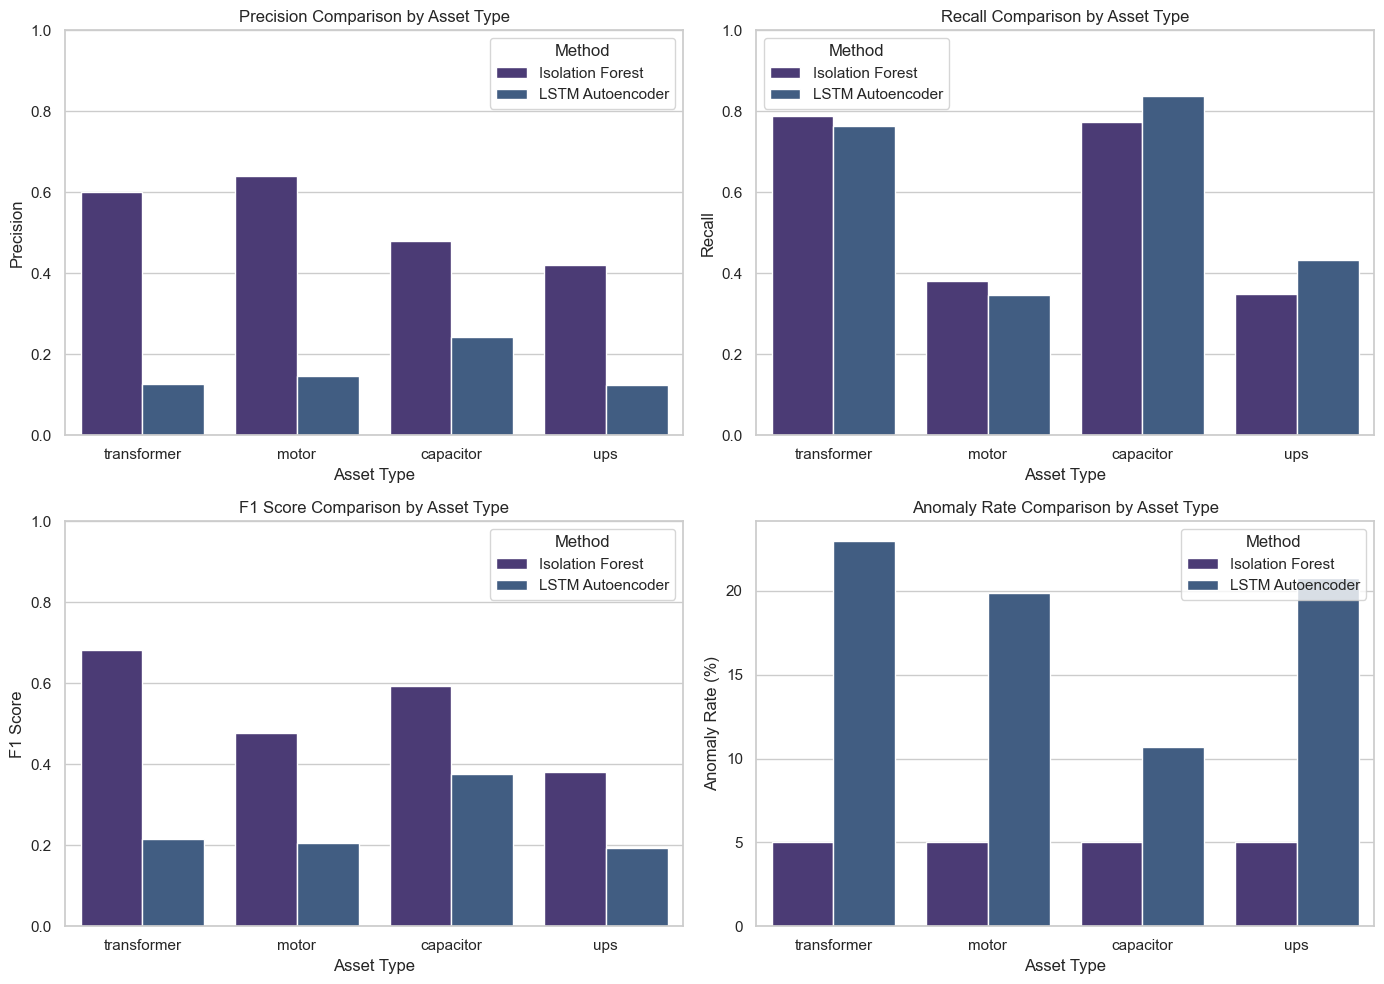


Anomaly detection comparison completed!
Check the 'results' directory for visualizations and comparison data.


In [32]:
# 4. Comparative Analysis of Anomaly Detection Methods
print("\nComparing anomaly detection methods...")

# Create comparison dataframe
comparison_data = []

for asset_type in ['transformer', 'motor', 'capacitor', 'ups']:
    iso_results = isolation_results[asset_type]
    lstm_data = lstm_results[asset_type]
    
    # For Isolation Forest, we need to evaluate against ground truth
    # Here we'll use a simplified approach for demonstration
    
    # Get ground truth (1 for Warning/Critical, 0 for Healthy)
    if asset_type == 'transformer':
        y = transformer_y
    elif asset_type == 'motor':
        y = motor_y
    elif asset_type == 'capacitor':
        y = capacitor_y
    else:
        y = ups_y
    
    y_true = np.where(y >= 1, 1, 0)
    
    # Isolation Forest metrics
    iso_pred = np.where(isolation_predictions[asset_type] == 1, 1, 0)
    iso_precision = np.sum((iso_pred == 1) & (y_true == 1)) / np.sum(iso_pred == 1) if np.sum(iso_pred == 1) > 0 else 0
    iso_recall = np.sum((iso_pred == 1) & (y_true == 1)) / np.sum(y_true == 1) if np.sum(y_true == 1) > 0 else 0
    iso_f1 = 2 * (iso_precision * iso_recall) / (iso_precision + iso_recall) if (iso_precision + iso_recall) > 0 else 0
    
    # LSTM Autoencoder metrics
    # For simplicity, we'll consider windows with anomalies as positive
    lstm_pred = np.zeros(len(y_true))
    anomalies = lstm_results[asset_type]['anomalies']
    # Map window anomalies to original time series (simplified)
    for i in range(len(anomalies)):
        if anomalies[i]:
            # Mark the window as anomalous
            lstm_pred[i:i+30] = 1  # Mark the entire window
    lstm_pred = lstm_pred[:len(y_true)]  # Truncate to original length
    
    lstm_precision = np.sum((lstm_pred == 1) & (y_true == 1)) / np.sum(lstm_pred == 1) if np.sum(lstm_pred == 1) > 0 else 0
    lstm_recall = np.sum((lstm_pred == 1) & (y_true == 1)) / np.sum(y_true == 1) if np.sum(y_true == 1) > 0 else 0
    lstm_f1 = 2 * (lstm_precision * lstm_recall) / (lstm_precision + lstm_recall) if (lstm_precision + lstm_recall) > 0 else 0
    
    comparison_data.append([
        asset_type,
        'Isolation Forest',
        iso_precision,
        iso_recall,
        iso_f1,
        iso_results['anomaly_percentage']
    ])
    comparison_data.append([
        asset_type,
        'LSTM Autoencoder',
        lstm_precision,
        lstm_recall,
        lstm_f1,
        np.mean(lstm_pred) * 100
    ])

comparison_df = pd.DataFrame(comparison_data, columns=[
    'Asset Type', 'Method', 'Precision', 'Recall', 'F1 Score', 'Anomaly Rate (%)'
])

# Plot comparison
plt.figure(figsize=(14, 10))

# Precision
plt.subplot(2, 2, 1)
sns.barplot(x='Asset Type', y='Precision', hue='Method', data=comparison_df)
plt.title('Precision Comparison by Asset Type')
plt.ylim(0, 1)

# Recall
plt.subplot(2, 2, 2)
sns.barplot(x='Asset Type', y='Recall', hue='Method', data=comparison_df)
plt.title('Recall Comparison by Asset Type')
plt.ylim(0, 1)

# F1 Score
plt.subplot(2, 2, 3)
sns.barplot(x='Asset Type', y='F1 Score', hue='Method', data=comparison_df)
plt.title('F1 Score Comparison by Asset Type')
plt.ylim(0, 1)

# Anomaly Rate
plt.subplot(2, 2, 4)
sns.barplot(x='Asset Type', y='Anomaly Rate (%)', hue='Method', data=comparison_df)
plt.title('Anomaly Rate Comparison by Asset Type')

plt.tight_layout()
plt.savefig('../results/anomaly_detection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save comparison results
comparison_df.to_csv('../results/anomaly_detection_comparison.csv', index=False)
print("\nAnomaly detection comparison completed!")
print("Check the 'results' directory for visualizations and comparison data.")